In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
#import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

from run_not import NotMnistGenerator


# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

/nfs/home/samuelk/anaconda2/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/nfs/home/samuelk/anaconda2/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/nfs/home/samuelk/anaconda2/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/nfs/home/sam

In [ ]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = 'ddm/data'

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

        last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception('Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

In [ ]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root)) \
                    if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception('Expected %d folders, one per class. Found %d instead.' % (num_classes, len(data_folders)))
    print(data_folders)
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

In [ ]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except (IOError, ValueError) as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

In [ ]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes

    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class

                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    
    return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets, train_size, 
                                                                        valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

In [ ]:
idx = np.random.permutation(train_dataset.shape[0])
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(9, 9),
                        subplot_kw={'xticks': [], 'yticks': []})

for i in range(len(axs.flat)):
    ax = axs.flat[i]
    ax.imshow(train_dataset[idx[i], :, :])
    ax.set_title("Label: {}".format(train_labels[idx[i]]))

plt.tight_layout()
plt.show()

In [ ]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [ ]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {'train_dataset': train_dataset,
            'train_labels': train_labels,
            'valid_dataset': valid_dataset,
            'valid_labels': valid_labels,
            'test_dataset': test_dataset,
            'test_labels': test_labels}
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [ ]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

In [2]:
data_gen = NotMnistGenerator(noise=True)
next_x_train, next_y_train, next_x_test, next_y_test, next_x_val, next_y_val = data_gen.next_task()
next_x_train.shape

(40000, 784)

In [3]:
next_x_train = next_x_train.reshape((-1, 28, 28))

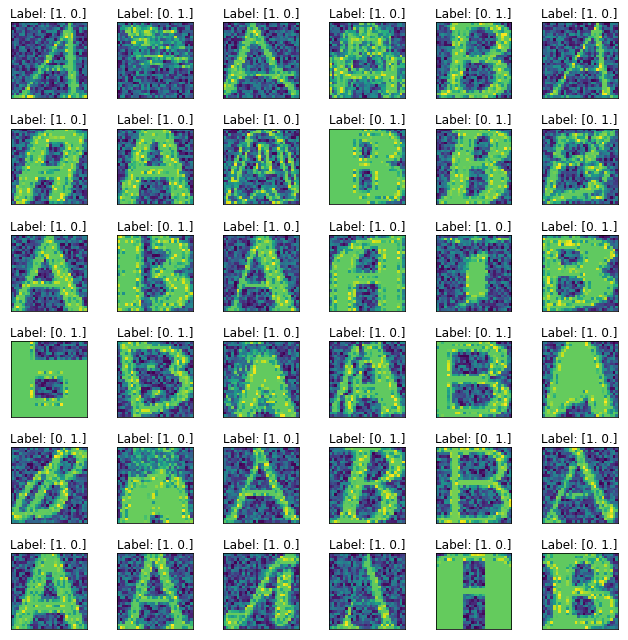

In [4]:
idx = np.random.permutation(next_x_train.shape[0])
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(9, 9),
                        subplot_kw={'xticks': [], 'yticks': []})

for i in range(len(axs.flat)):
    ax = axs.flat[i]
    ax.imshow(next_x_train[idx[i], :, :])
    ax.set_title("Label: {}".format(next_y_train[idx[i], :]))

plt.tight_layout()
plt.show()

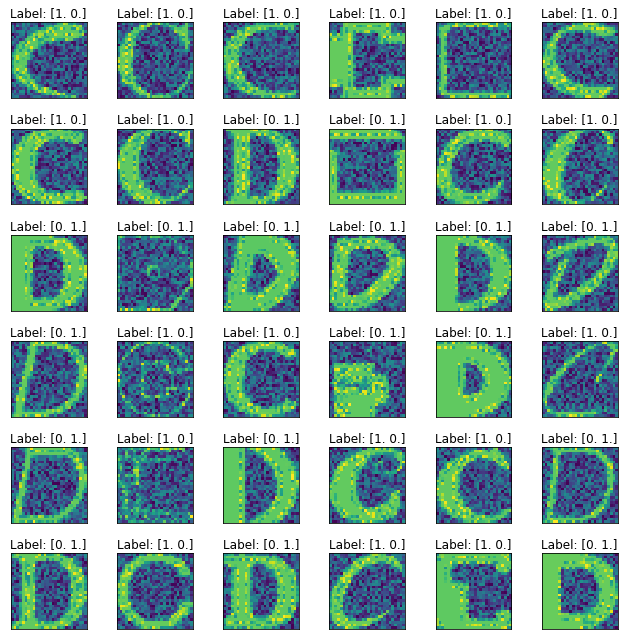

In [5]:
next_x_train, next_y_train, next_x_test, next_y_test, next_x_val, next_y_val = data_gen.next_task()
next_x_train = next_x_train.reshape((-1, 28, 28))
idx = np.random.permutation(next_x_train.shape[0])
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(9, 9),
                        subplot_kw={'xticks': [], 'yticks': []})

for i in range(len(axs.flat)):
    ax = axs.flat[i]
    ax.imshow(next_x_train[idx[i], :, :])
    ax.set_title("Label: {}".format(next_y_train[idx[i], :]))

plt.tight_layout()
plt.show()

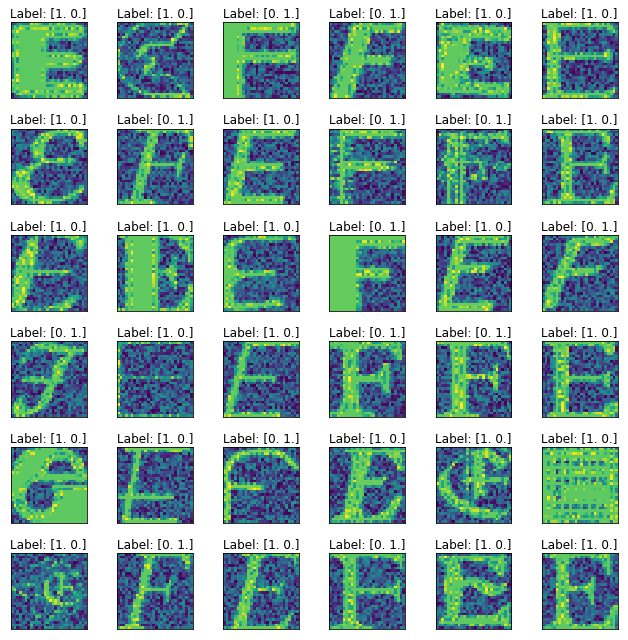

In [6]:
next_x_train, next_y_train, next_x_test, next_y_test, next_x_val, next_y_val = data_gen.next_task()
next_x_train = next_x_train.reshape((-1, 28, 28))
idx = np.random.permutation(next_x_train.shape[0])
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(9, 9),
                        subplot_kw={'xticks': [], 'yticks': []})

for i in range(len(axs.flat)):
    ax = axs.flat[i]
    ax.imshow(next_x_train[idx[i], :, :])
    ax.set_title("Label: {}".format(next_y_train[idx[i], :]))

plt.tight_layout()
plt.show()

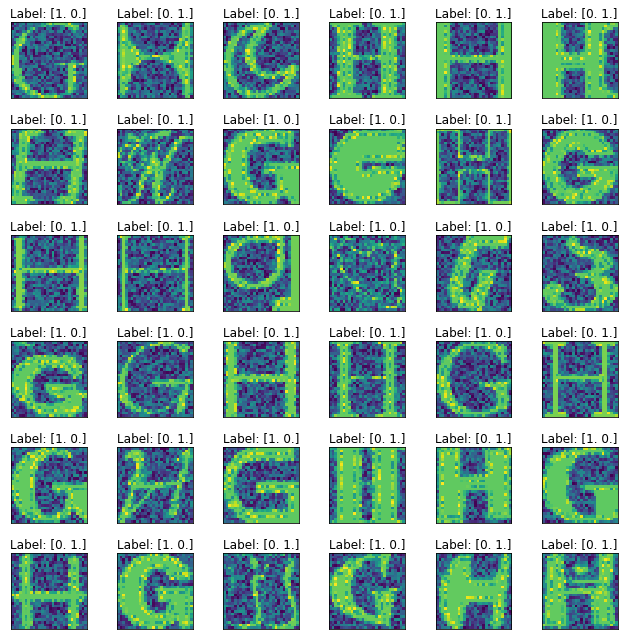

In [7]:
next_x_train, next_y_train, next_x_test, next_y_test, next_x_val, next_y_val = data_gen.next_task()
next_x_train = next_x_train.reshape((-1, 28, 28))
idx = np.random.permutation(next_x_train.shape[0])
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(9, 9),
                        subplot_kw={'xticks': [], 'yticks': []})

for i in range(len(axs.flat)):
    ax = axs.flat[i]
    ax.imshow(next_x_train[idx[i], :, :])
    ax.set_title("Label: {}".format(next_y_train[idx[i], :]))

plt.tight_layout()
plt.show()

# Random and Background datasets

In [3]:
from run_split import SplitMnistBackgroundGenerator
data_gen = SplitMnistBackgroundGenerator(val=True)
next_x_train, next_y_train, next_x_test, next_y_test, next_x_val, next_y_val = data_gen.next_task()
next_x_train.shape

(8453, 784)

In [ ]:
next_x_train = next_x_train.reshape((-1, 28, 28))

In [ ]:
next_x_test.mean()

In [ ]:
next_x_test.std()

In [ ]:
import skimage
idx = np.random.permutation(next_x_train.shape[0])
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(9, 9),
                        subplot_kw={'xticks': [], 'yticks': []})

for i in range(len(axs.flat)):
    ax = axs.flat[i]
    ax.imshow(skimage.transform.rotate(next_x_train[idx[i], :, :], 270))
    ax.set_title("Label: {}".format(next_y_train[idx[i], :]))

plt.tight_layout()
plt.show()

In [ ]:
from run_split import SplitMnistRandomGenerator
data_gen = SplitMnistRandomGenerator(val=True)
next_x_train, next_y_train, next_x_test, next_y_test, next_x_val, next_y_val = data_gen.next_task()
next_x_train.shape

In [ ]:
next_x_train = next_x_train.reshape((-1, 28, 28))

In [ ]:
idx = np.random.permutation(next_x_train.shape[0])
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(9, 9),
                        subplot_kw={'xticks': [], 'yticks': []})

for i in range(len(axs.flat)):
    ax = axs.flat[i]
    ax.imshow(skimage.transform.rotate(next_x_train[idx[i], :, :], 270))
    ax.set_title("Label: {}".format(next_y_train[idx[i], :]))

plt.tight_layout()
plt.show()

In [ ]:
import gzip
with gzip.open('data/mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
print(train_set[0].shape)
print(valid_set[0].shape)
print(test_set[0].shape)

In [ ]:
train_set[0].mean()

In [ ]:
train_set[0].std()

# CIFAR 10

In [2]:
import tensorflow as tf
train, test = tf.compat.v1.keras.datasets.cifar10.load_data() # (50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1)

In [3]:
import numpy as np
np.unique(test[1])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [8]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

labels = load_label_names()

In [5]:
train[0].shape

(50000, 32, 32, 3)

In [6]:
_train = train[0].reshape(-1, 32*32*3)

In [7]:
_train.shape

(50000, 3072)

In [8]:
_train_labels = train[1].reshape(-1)
_train_labels.shape

(50000,)

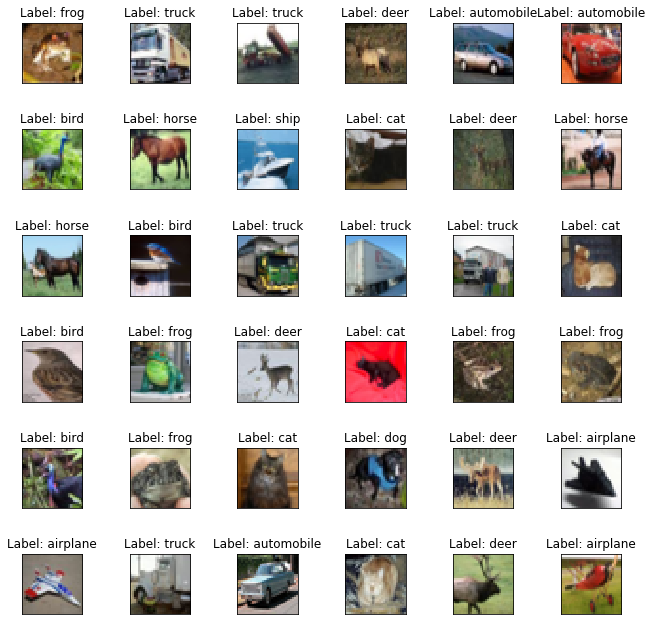

In [9]:
idx = np.random.permutation(train[0].shape[0])
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(9, 9),
                        subplot_kw={'xticks': [], 'yticks': []})

for i in range(len(axs.flat)):
    ax = axs.flat[i]
    ax.imshow(_train[i, :].reshape(32, 32, 3))
    ax.set_title("Label: {}".format(labels[_train_labels[i]]))

plt.tight_layout()
plt.show()

In [10]:
train[1][:10].shape

(10, 1)

In [2]:
from run_split import SplitCIFAR10Generator
data_gen = SplitCIFAR10Generator(val=True)
next_x_train, next_y_train, next_x_test, next_y_test, next_x_val, next_y_val = data_gen.next_task()
next_x_train.shape

(7974, 3072)

In [3]:
next_x_train = next_x_train.reshape((-1, 32, 32, 3))

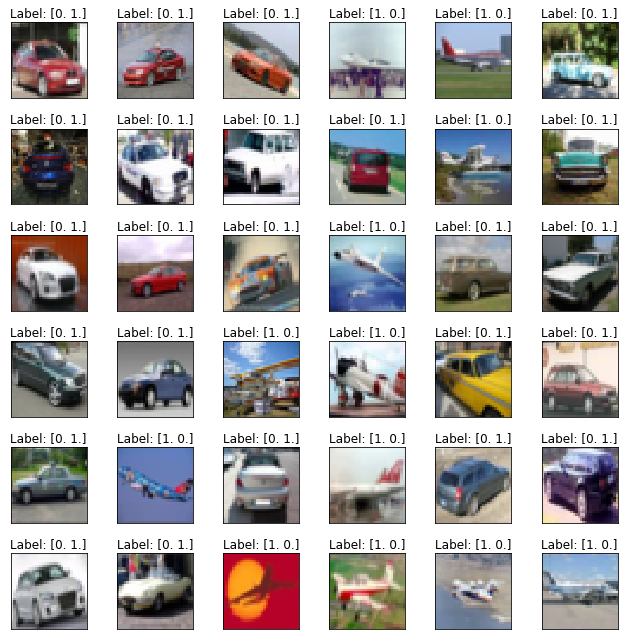

In [4]:
idx = np.random.permutation(next_x_train.shape[0])
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(9, 9),
                        subplot_kw={'xticks': [], 'yticks': []})

for i in range(len(axs.flat)):
    ax = axs.flat[i]
    ax.imshow(next_x_train[idx[i], :, :, :])
    ax.set_title("Label: {}".format(next_y_train[idx[i], :]))

plt.tight_layout()
plt.show()

In [6]:
from run_split import SplitCIFAR10MNIST
val = False
data_gen = SplitCIFAR10MNIST(val=val)
if val:
    next_x_train, next_y_train, next_x_test, next_y_test, next_x_val, next_y_val = data_gen.next_task()
else:
    next_x_train, next_y_train, next_x_test, next_y_test = data_gen.next_task()
next_x_train.shape

(12665, 1024)

In [7]:
next_x_train = next_x_train.reshape((-1, 32, 32))

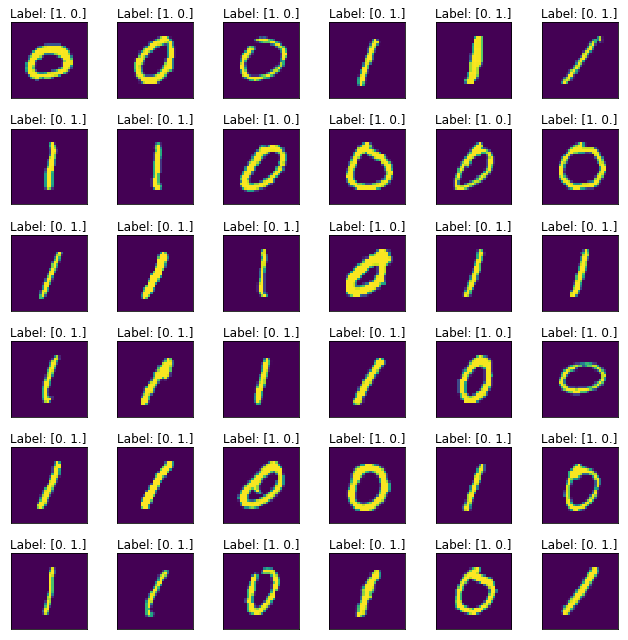

In [8]:
idx = np.random.permutation(next_x_train.shape[0])
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(9, 9),
                        subplot_kw={'xticks': [], 'yticks': []})

for i in range(len(axs.flat)):
    ax = axs.flat[i]
    ax.imshow(next_x_train[idx[i], :, :])
    ax.set_title("Label: {}".format(next_y_train[idx[i], :]))

plt.tight_layout()
plt.show()

In [12]:
data_gen.set_cur_iter(4)
if val:
    next_x_train, next_y_train, next_x_test, next_y_test, next_x_val, next_y_val = data_gen.next_task()
else:
    next_x_train, next_y_train, next_x_test, next_y_test = data_gen.next_task()
next_x_train.shape

(10000, 1024)

In [13]:
next_x_train = next_x_train.reshape((-1, 32, 32))

In [14]:
next_y_train[idx[i], :]

array([1., 0.])

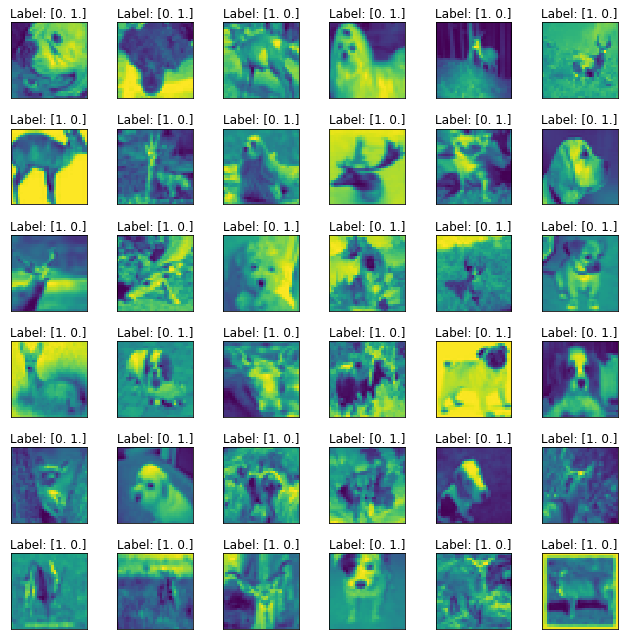

In [15]:
idx = np.random.permutation(next_x_train.shape[0])
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(9, 9),
                        subplot_kw={'xticks': [], 'yticks': []})

for i in range(len(axs.flat)):
    ax = axs.flat[i]
    ax.imshow(next_x_train[idx[i], :, :])
    ax.set_title("Label: {}".format(next_y_train[idx[i], :]))
plt.tight_layout()
plt.show()

In [11]:
from run_split import SplitMnistGenerator
val = False
cl3 = True
data_gen = SplitMnistGenerator(val=val, cl3=cl3)
data_gen.set_cur_iter(0)
if val:
    next_x_train, next_y_train, next_x_test, next_y_test, next_x_val, next_y_val = data_gen.next_task()
else:
    next_x_train, next_y_train, next_x_test, next_y_test = data_gen.next_task()
next_x_train.shape

(12665, 784)

In [12]:
next_x_train = next_x_train.reshape((-1, 28, 28))

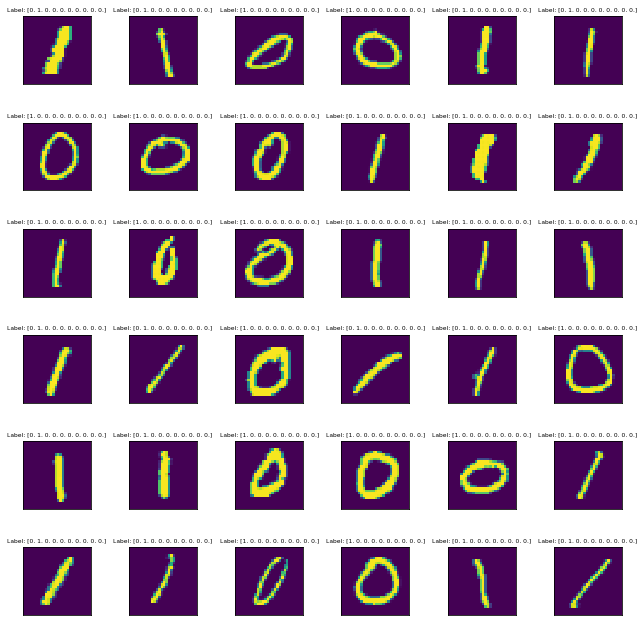

In [13]:
idx = np.random.permutation(next_x_train.shape[0])
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(9, 9),
                        subplot_kw={'xticks': [], 'yticks': []})

for i in range(len(axs.flat)):
    ax = axs.flat[i]
    ax.imshow(next_x_train[idx[i], :, :])
    ax.set_title("Label: {}".format(next_y_train[idx[i], :]), fontsize=6)
plt.tight_layout()
plt.show()


In [ ]:
from run_split import SplitMnistGenerator
val = False
cl3 = True
data_gen = SplitMnistGenerator(val=val, cl3=cl3)
if val:
    next_x_train, next_y_train, next_x_test, next_y_test, next_x_val, next_y_val = data_gen.next_task()
else:
    next_x_train, next_y_train, next_x_test, next_y_test = data_gen.next_task()
next_x_train.shape

ImportError: This version of TensorFlow Probability requires TensorFlow version >= 1.15; Detected an installation of version 1.14.0. Please upgrade TensorFlow to proceed.

In [ ]:
idx = np.random.permutation(next_x_train.shape[0])
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(9, 9),
                        subplot_kw={'xticks': [], 'yticks': []})

for i in range(len(axs.flat)):
    ax = axs.flat[i]
    ax.imshow(next_x_train[idx[i], :, :])
    ax.set_title("Label: {}".format(next_y_train[idx[i], :]))
plt.tight_layout()
plt.show()
